In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mode
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython.display import Image
from random import random
import random as rand

import matplotlib.style
import matplotlib as mpl
mpl.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size':14})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values),3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values),3)))
    
    print("Train RMSE:\t" + str(round(np.sqrt(mse(train_true_values, train_pred_values)),3)))
    print("Test RMSE:\t" + str(round(np.sqrt(mse(test_true_values, test_pred_values)),3)))
    
    print("Train MSE:\t" + str(round(mse(train_true_values, train_pred_values), 3)))
    print("Test MSE:\t" + str(round(mse(test_true_values, test_pred_values), 3)))
    
    print(f"Train Mean-Target: {round(np.mean(train_true_values), 3)}")
    print(f"Test Mean-Target: {round(np.mean(test_true_values), 3)}")
          
    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values, color='purple')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample predictions', size=20, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values, color='purple')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample predictions', size=20, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.show()

## Directories

In [4]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

# Dataset description:

##### Id - identification number of the apartment
##### DistrictId - district identification number
##### Rooms - number of rooms
##### Square - square
##### LifeSquare - living space
##### KitchenSquare - kitchen area
##### Floor - floor
##### HouseFloor - number of floors in the house
##### HouseYear - the year the house was built
##### Ecology_1, Ecology_2, Ecology_3 - ecological indicators of the area
##### Social_1, Social_2, Social_3 - social indicators of the area
##### Healthcare_1, Helthcare_2 - area indicators related to health protection
##### Shops_1, Shops_2 - indicators related to the presence of stores, shopping centers
##### Price - apartment price

In [5]:
train_df=pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [6]:
test_df=pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [7]:
train_df.shape[1]-1 == test_df.shape[1]

True

In [8]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [9]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

#### Change ID & DistrictId as string object

In [10]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### Check "Distribution of Price" Bar Chart

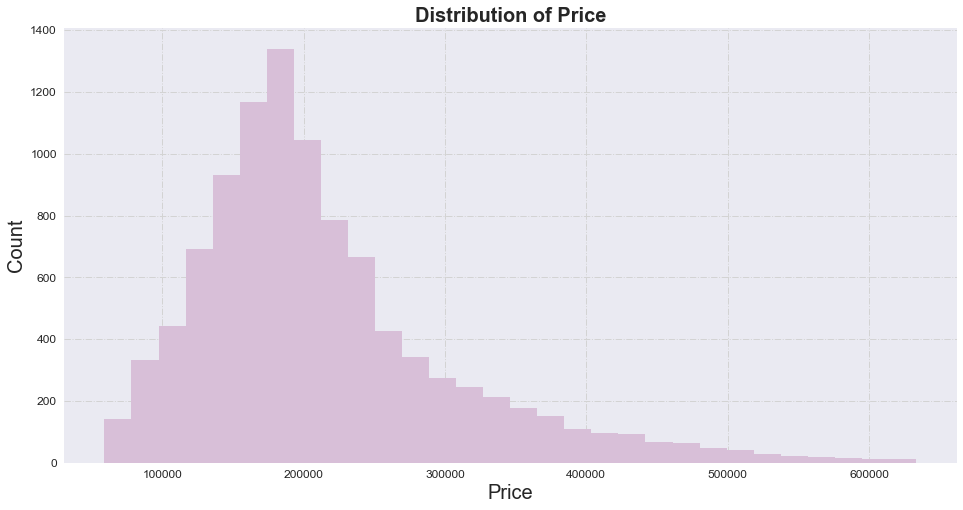

In [11]:
plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 8})
train_df['Price'].hist(density=False, bins=30, color = ['thistle'])

plt.ylabel('Count', size=20)
plt.xlabel('Price', size=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle="-.", color='lightgrey')
plt.bar
plt.title('Distribution of Price', size=20, fontweight='bold')
plt.show()

### Calculate mean, median and mode of the Price

In [12]:
target_mean=round(train_df['Price'].mean(),2)
target_median=train_df['Price'].median()
target_mode=train_df['Price'].mode()[0]

print(f'Mean = {target_mean}, Median = {target_median}, Mode = {target_mode}')

Mean = 214138.86, Median = 192269.64487934904, Mode = 59174.77802758122


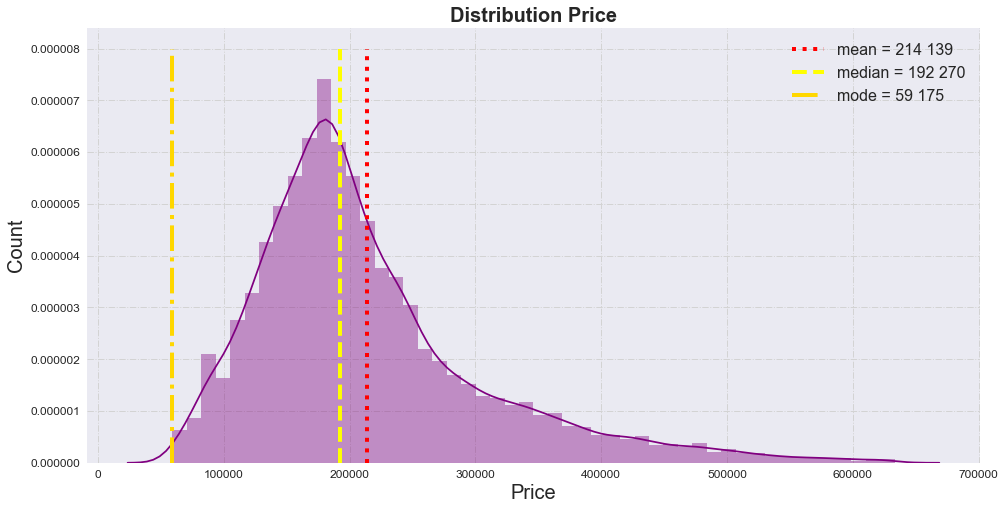

In [13]:
plt.figure(figsize=(16,8))

sns.distplot(train_df['Price'], bins=50, color = 'purple')

y=np.linspace(0, 0.000008, 10)
plt.plot([target_mean]*10, y, label='mean = 214 139', linestyle=':', linewidth=4, color = 'red')
plt.plot([target_median]*10, y, label='median = 192 270', linestyle='--', linewidth=4, color = 'yellow')
plt.plot([target_mode]*10, y, label='mode = 59 175', linestyle='-.', linewidth=4, color = 'gold')

plt.ylabel('Count', size=20)
plt.xlabel('Price', size=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle="-.", color='lightgrey')
plt.title('Distribution Price', size=20, fontweight='bold')
plt.legend(fancybox=True, shadow=True, fontsize=16)
plt.show()

### Check dataset measures

In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [15]:
cat_colnames=train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

### Check categories and their proportion

In [16]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' *100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



### Transform data
#### Rooms

In [17]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

### Replace droppings with median

In [18]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms']=train_df['Rooms'].median()

### Square, LifeSquare, KitchenSquare

In [19]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Release excess data by quantile for less discrepancies and more legal data

In [20]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [21]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8881.000000,8881.000000,7296.000000,8881.000000,8881.000000,8881.000000,8.881000e+03,8881.000000,8881.000000,8881.000000,8881.000000,4799.000000,8881.000000,8881.000000,8881.000000
mean,1.884585,54.809487,34.830304,6.075329,8.446684,12.826934,4.242532e+03,0.119620,26.071163,5630.480014,8.403783,1156.072932,1.392636,4.438577,214939.479049
std,0.797003,16.225349,14.280535,3.503611,5.133763,6.369206,2.127571e+05,0.119654,17.269698,3977.902810,24.295214,1032.814421,1.492092,4.837340,89654.209673
min,1.000000,29.719934,2.941437,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.637555,22.863805,1.000000,4.000000,9.000000,1.972000e+03,0.017647,10.000000,2370.000000,0.000000,325.000000,0.000000,1.000000,156934.440088
50%,2.000000,51.656012,32.459931,6.000000,7.000000,14.000000,1.977000e+03,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194240.534503
75%,2.000000,64.720916,44.119769,9.000000,12.000000,17.000000,2.000000e+03,0.194489,36.000000,7614.000000,5.000000,1548.000000,3.000000,6.000000,250381.580780
max,6.000000,117.855969,88.381356,14.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Check for discrepancies where the total area is less than the total size of the kitchen and living area

In [22]:
mask = train_df['Square'] < train_df['KitchenSquare'] + train_df['LifeSquare']
train_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,652.000000,250.000000,652.000000,652.000000,652.000000
mean,1.648773,53.937687,53.975295,4.766871,9.946319,14.760736,2000.834356,0.107157,16.115031,3707.608896,9.110429,889.080000,0.878834,3.461656,190942.451129
std,0.735922,14.718972,14.697441,4.290268,5.805755,8.616302,19.706764,0.109550,16.929164,3944.012120,29.387084,723.285122,1.344859,5.290638,85871.143763
min,1.000000,29.719934,22.892380,1.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59877.592523
25%,1.000000,41.318307,41.593619,1.000000,5.000000,10.000000,1977.000000,0.011654,2.000000,629.000000,0.000000,540.000000,0.000000,0.000000,132108.091249
50%,1.000000,51.306312,50.900047,1.000000,9.000000,17.000000,2015.000000,0.072158,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,171791.694650
75%,2.000000,64.653077,64.342662,10.000000,14.000000,17.000000,2017.000000,0.195781,26.000000,6138.000000,4.000000,1046.000000,2.000000,5.000000,228633.695836
max,5.000000,89.118209,88.381356,14.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,573539.701956


### Accept the minimum indicators for the area LifeSquare & KitchenSquare

In [23]:
train_df.loc[train_df['LifeSquare'] < 8, 'LifeSquare'] = 8

In [24]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

### HouseFloor, Floor

In [25]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.])

In [26]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 42],
      dtype=int64)

### Replace illogically entered data with averages (example for HouseFloor)

In [27]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [28]:
floor_outliers = train_df[train_df['Floor'] > train_df['HouseFloor']].index
print(len(floor_outliers))

train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: rand.randint(1, x)
)

1404


In [29]:
train_df.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: rand.randint(1, x)
)

14       2
16       2
21       1
35       1
51       9
        ..
9984     6
9985     1
9989    24
9991     8
9995     2
Name: HouseFloor, Length: 1404, dtype: int64

### HouseYear

In [30]:
train_df['HouseYear'].value_counts().sort_index()

1914          1
1916          1
1917          3
1918          4
1919          3
           ... 
2018        136
2019         57
2020         18
4968          1
20052011      1
Name: HouseYear, Length: 95, dtype: int64

In [31]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

### Empty Data

In [32]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

### LifeSquare

In [33]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,7.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,7.0
8,64.511437,NaN,3.0
9,46.461409,18.915552,8.0
10,46.304907,27.922584,6.0
11,68.808859,45.736906,7.0


In [34]:
train_df['LifeSquare'].median()

32.459930868446605

In [35]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                  train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                  train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()
square_med_diff

11.490551802890103

In [36]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [37]:
train_df['LifeSquare'].median()

33.273699979715275

### Healthcare_1

In [38]:
train_df['Healthcare_1'].head()

0       NaN
1     240.0
3    1084.0
4    2078.0
5     990.0
Name: Healthcare_1, dtype: float64

In [39]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

### New features

In [40]:
train_df["Ecology_2"]

0       B
1       B
3       B
4       B
5       B
       ..
9995    B
9996    B
9997    B
9998    B
9999    B
Name: Ecology_2, Length: 8881, dtype: object

In [41]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

### District Size

In [42]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,628
1,1,537
2,23,449
3,6,396
4,9,279


In [43]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,990.0,0,11,B,184966.930730,1,1,1,20
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,86
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,146
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,95
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,4,990.0,0,6,B,215898.447742,1,1,1,54


In [44]:
(train_df['DistrictSize'] > 100).value_counts()

False    4938
True     3943
Name: DistrictSize, dtype: int64

In [45]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,990.0,0,11,B,184966.930730,1,1,1,20,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,B,300009.450063,1,1,1,86,0
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,B,175616.227217,1,1,1,146,1
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,B,150226.531644,1,1,1,95,0
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,990.0,0,6,B,215898.447742,1,1,1,54,0


### Median Price By District

In [46]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,147258.736617
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146154.352249
4,1,2.0,202944.331497


In [47]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,20,0,203384.328026
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,86,0,300009.450063
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,146,1,169246.115943
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,95,0,158791.017955
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,0,6,B,215898.447742,1,1,1,54,0,384517.540046


In [48]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [49]:
test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
Id                    5000 non-null int64
DistrictId            5000 non-null object
Rooms                 5000 non-null float64
Square                5000 non-null float64
LifeSquare            3959 non-null float64
KitchenSquare         5000 non-null float64
Floor                 5000 non-null int64
HouseFloor            5000 non-null float64
HouseYear             5000 non-null int64
Ecology_1             5000 non-null float64
Ecology_2             5000 non-null object
Ecology_3             5000 non-null object
Social_1              5000 non-null int64
Social_2              5000 non-null int64
Social_3              5000 non-null int64
Healthcare_1          2623 non-null float64
Helthcare_2           5000 non-null int64
Shops_1               5000 non-null int64
Shops_2               5000 non-null object
MedPriceByDistrict    4919 non-null float64
dtypes: float64(8), int64(8), obj

### Median Price By House Year

In [50]:
med_price_by_houseyear = train_df.groupby(['HouseYear', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByHouseYear'})

med_price_by_houseyear.head()

,HouseYear,Rooms,MedPriceByHouseYear
0,1914,2.0,423580.477982
1,1916,3.0,284608.939261
2,1917,1.0,236830.764637
3,1917,2.0,69623.753191
4,1917,3.0,486057.129888


In [51]:
train_df = train_df.merge(med_price_by_houseyear, on=['HouseYear', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedPriceByHouseYear
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,11,B,184966.930730,1,1,1,20,0,203384.328026,194564.197909
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,16,B,300009.450063,1,1,1,86,0,300009.450063,268711.924550
2,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5,B,175616.227217,1,1,1,146,1,169246.115943,183561.265705
3,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,4,B,150226.531644,1,1,1,95,0,158791.017955,167876.802185
4,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,6,B,215898.447742,1,1,1,54,0,384517.540046,231715.747693


In [52]:
test_df['HouseYear'] = test_df['HouseYear'].astype(int)

In [53]:
test_df.merge(med_price_by_houseyear, on=['HouseYear', 'Rooms'], how='left').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
Id                     5000 non-null int64
DistrictId             5000 non-null object
Rooms                  5000 non-null float64
Square                 5000 non-null float64
LifeSquare             3959 non-null float64
KitchenSquare          5000 non-null float64
Floor                  5000 non-null int64
HouseFloor             5000 non-null float64
HouseYear              5000 non-null int32
Ecology_1              5000 non-null float64
Ecology_2              5000 non-null object
Ecology_3              5000 non-null object
Social_1               5000 non-null int64
Social_2               5000 non-null int64
Social_3               5000 non-null int64
Healthcare_1           2623 non-null float64
Helthcare_2            5000 non-null int64
Shops_1                5000 non-null int64
Shops_2                5000 non-null object
MedPriceByHouseYear    4947 non-null float64
dtypes: float

In [54]:
test_df.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [55]:
train_df.Ecology_2

0       B
1       B
2       B
3       B
4       B
       ..
8876    B
8877    B
8878    B
8879    B
8880    B
Name: Ecology_2, Length: 8881, dtype: object

In [56]:
train_df.Ecology_3

0       B
1       B
2       B
3       B
4       B
       ..
8876    B
8877    B
8878    B
8879    A
8880    B
Name: Ecology_3, Length: 8881, dtype: object

In [57]:
train_df["Eco2_Eco3"] = train_df.Ecology_2 + train_df.Ecology_3
train_df.groupby(["Floor"])["Rooms"].mean()

Floor
1     1.813084
2     1.905229
3     1.884346
4     1.965363
5     1.877844
6     1.890940
7     1.969745
8     1.887015
9     1.922222
10    1.812672
11    1.802899
12    1.755784
13    1.850534
14    1.900356
15    1.876106
16    1.876106
17    1.908602
18    1.945455
19    1.836735
20    1.833333
21    1.729730
22    2.162162
23    1.941176
24    1.840000
25    2.250000
28    1.500000
31    1.000000
32    1.000000
33    1.000000
42    2.000000
Name: Rooms, dtype: float64

In [58]:
gp = train_df.Ecology_2 + train_df.Ecology_3
gp.value_counts()

BB    8525
BA     267
AB      89
dtype: int64

### Feature names

In [59]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'MedPriceByHouseYear',
 'Eco2_Eco3']

In [60]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict','MedPriceByHouseYear']

target_name = 'Price'

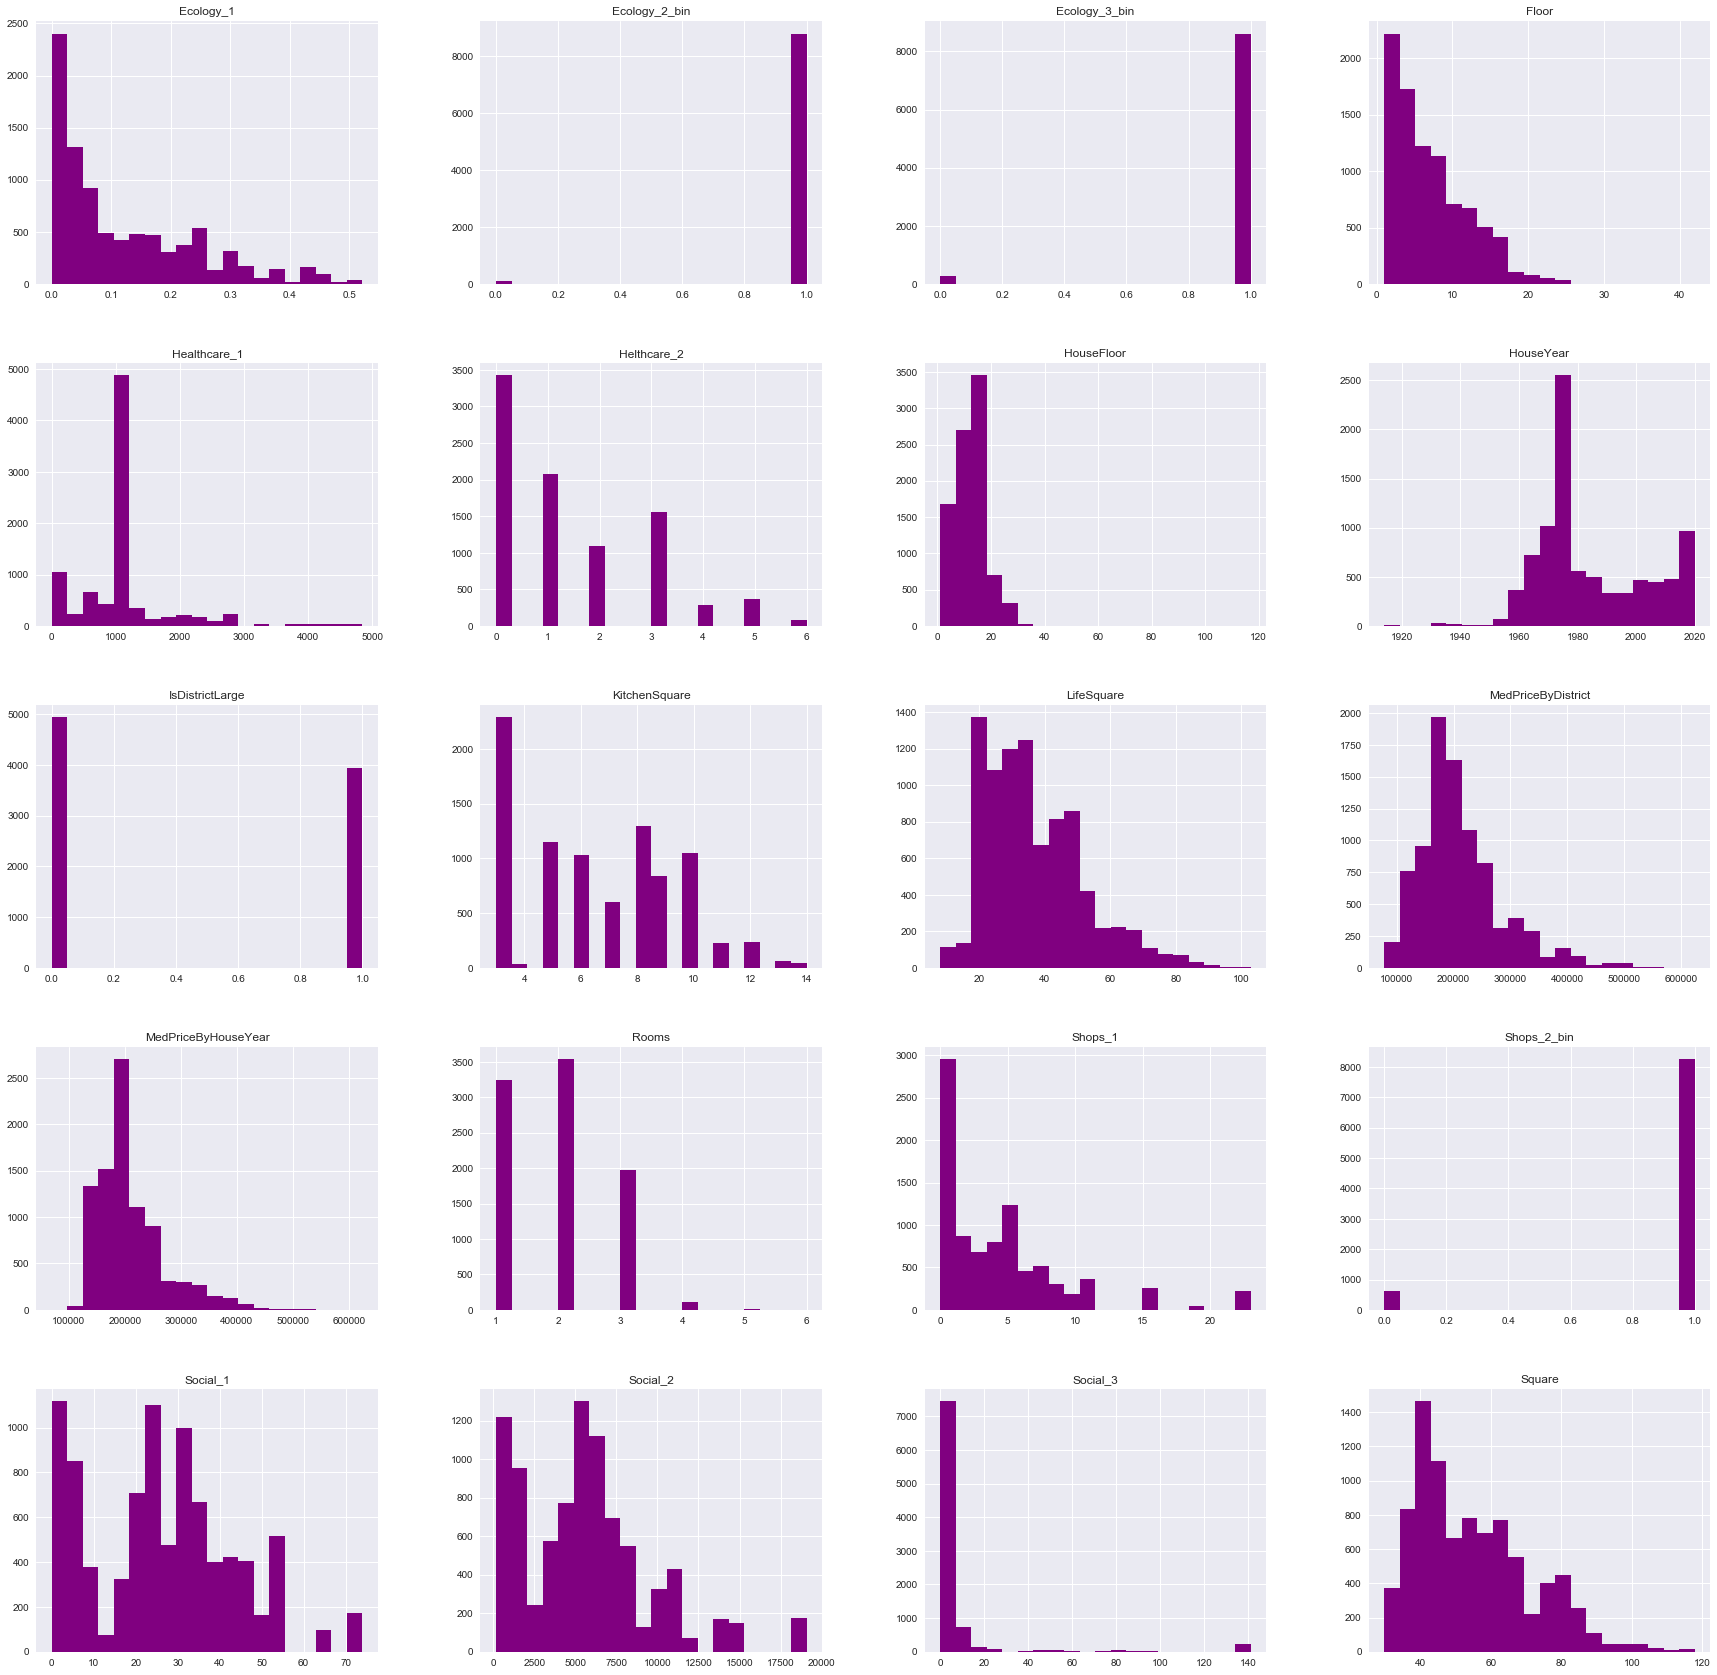

In [61]:
features=train_df[feature_names + new_feature_names]

features.hist(figsize=(30, 30), bins=20, grid=True, color = 'purple');

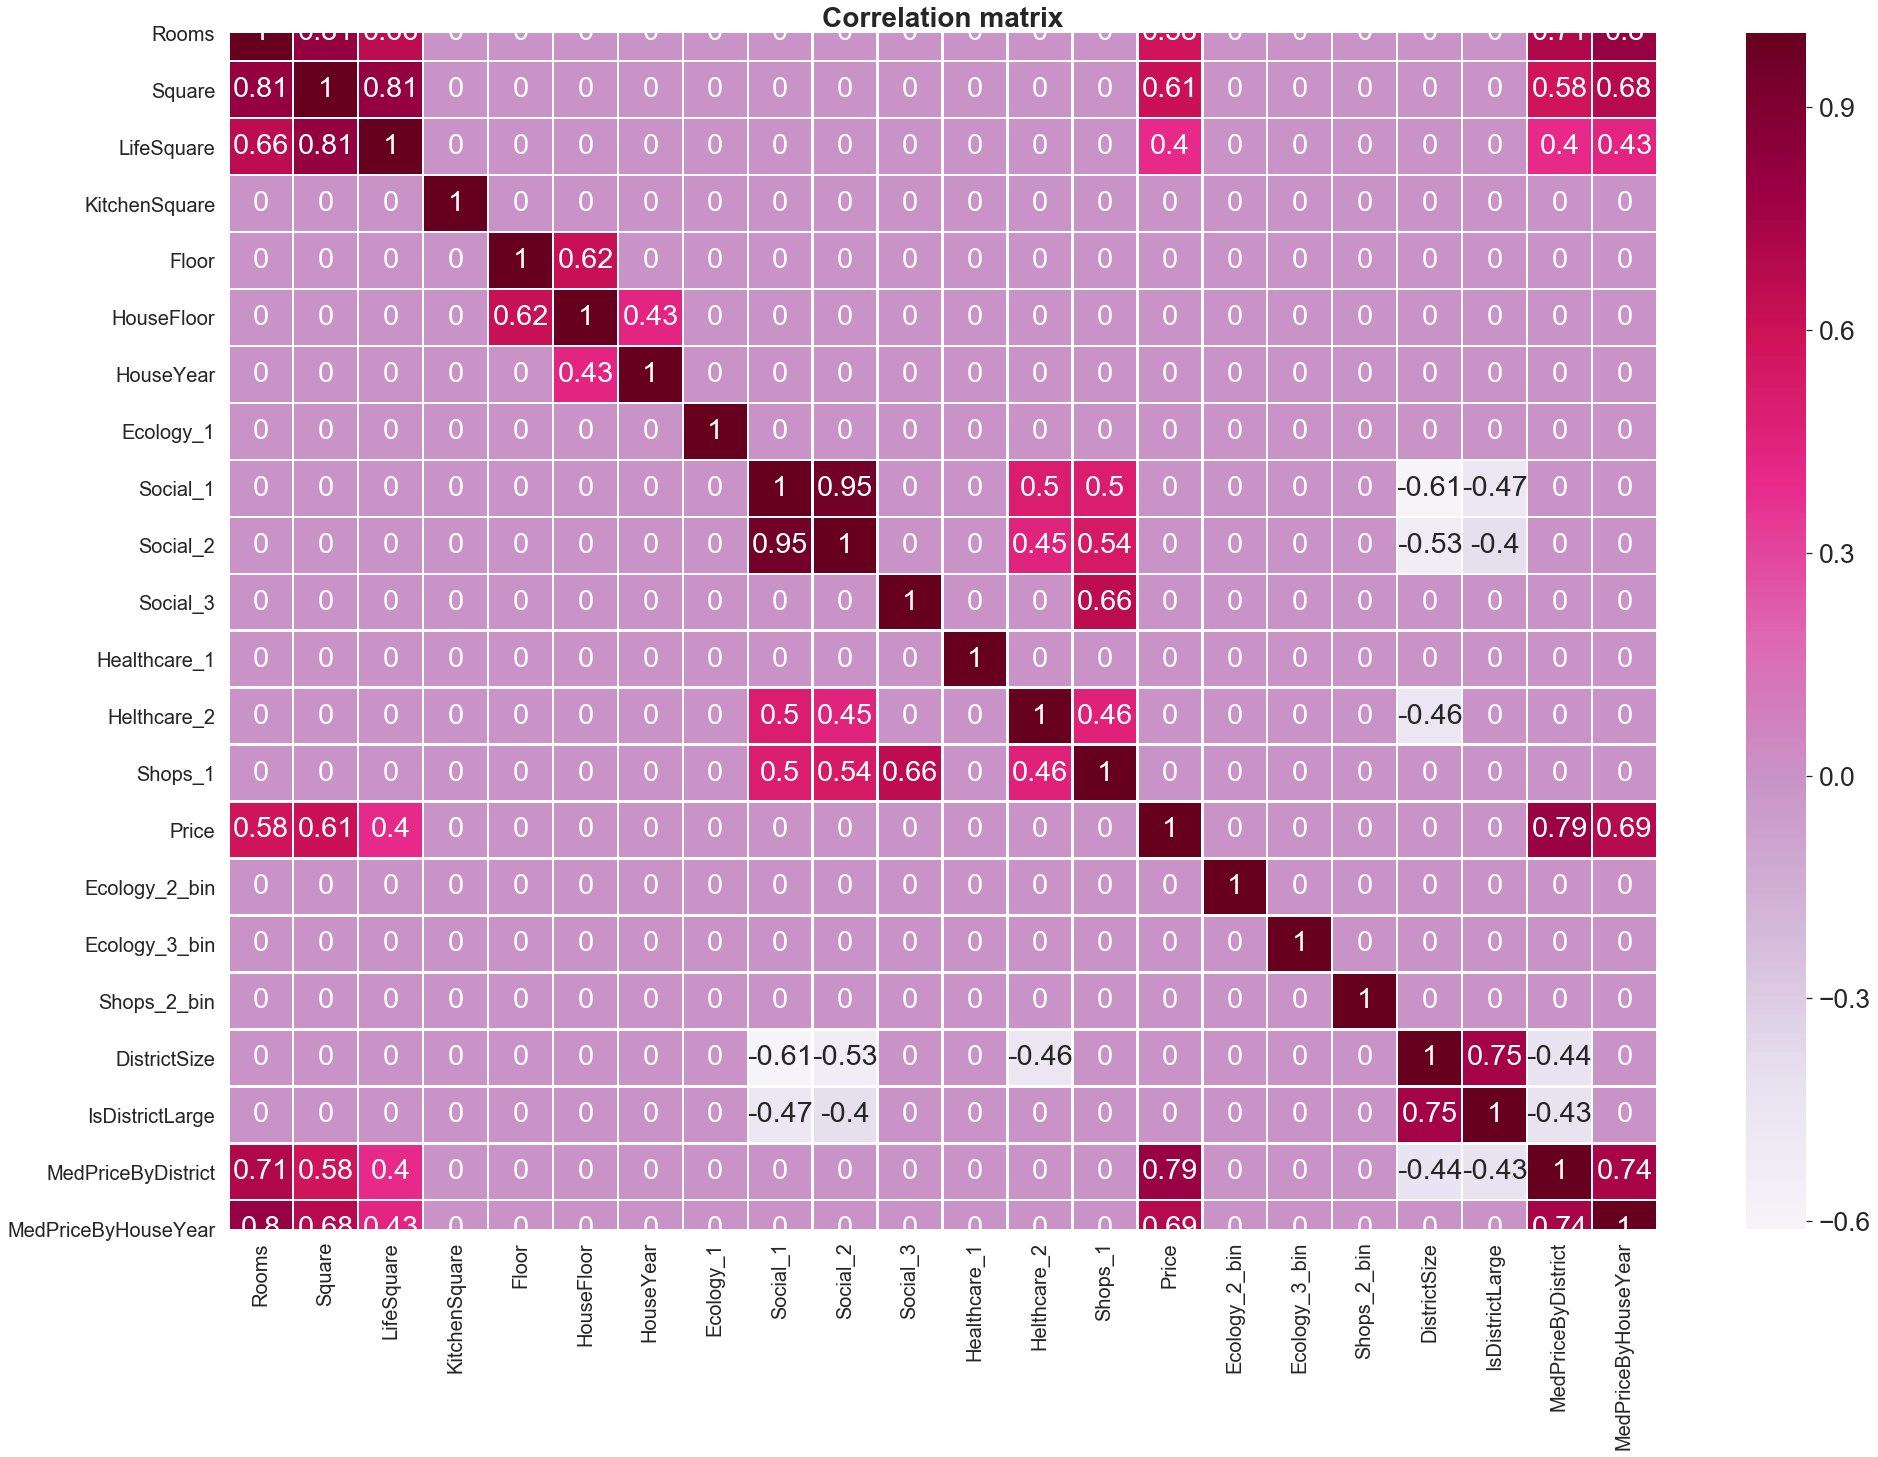

In [62]:
plt.figure(figsize=(32,22))

sns.set(font_scale=2.4)

corr_matrix=train_df.corr()
corr_matrix=np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix)<0.4] = 0

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.heatmap(corr_matrix, annot=True, linewidths=1.5, cmap='PuRd')

plt.title('Correlation matrix', size=28, fontweight='bold')
plt.show()

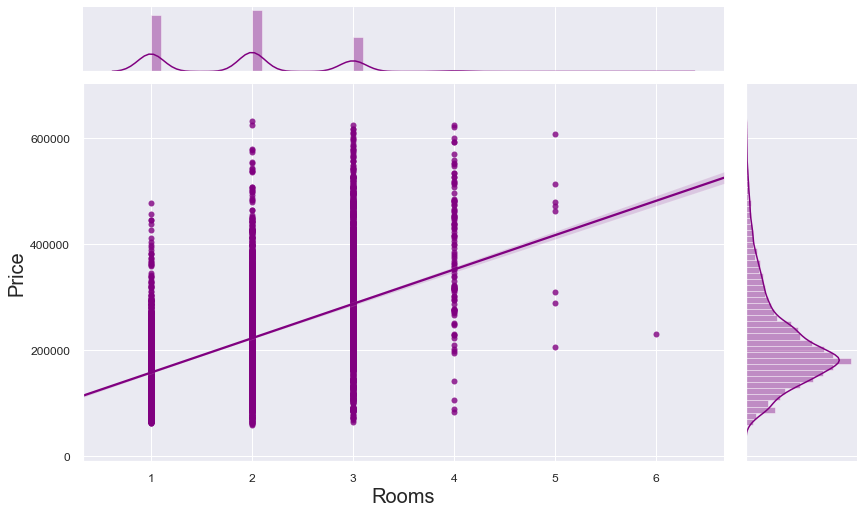

In [63]:
grid=sns.jointplot(train_df['Rooms'],train_df['Price'], kind='reg',  color = 'purple')
grid.fig.set_figwidth(16)
grid.fig.set_figheight(9)

plt.rcParams["figure.autolayout"] = True

plt.ylabel('Price', size=20)
plt.xlabel('Rooms', size=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

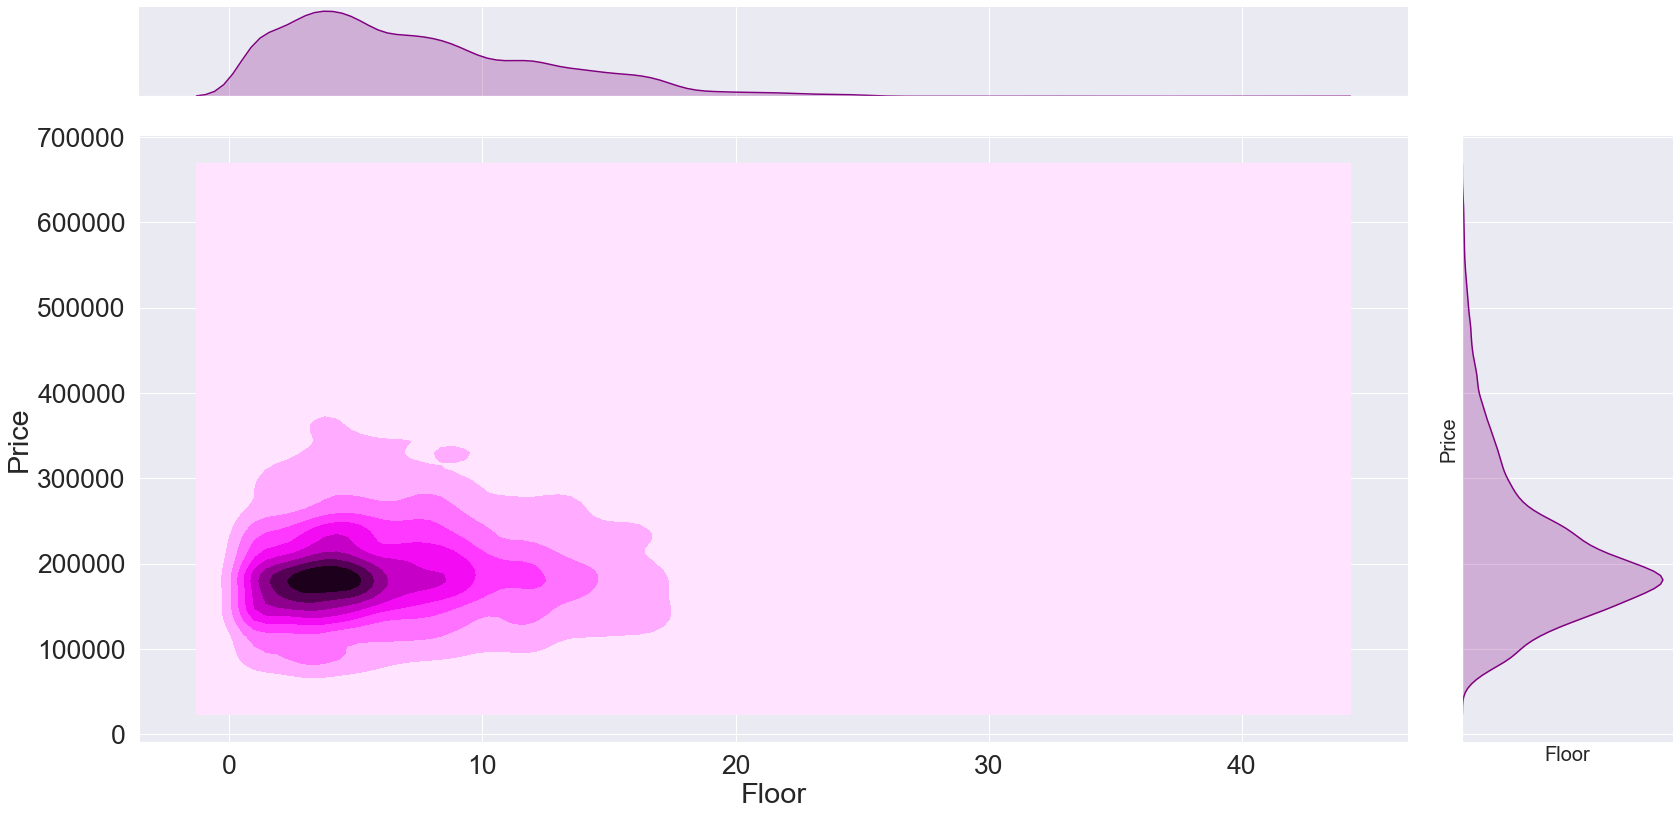

In [64]:
grid=sns.jointplot(train_df['Floor'],train_df['Price'], kind='kde', color='purple')
grid.fig.set_figwidth(24)
grid.fig.set_figheight(12)

plt.rcParams["figure.autolayout"] = True

plt.ylabel('Price', size=20)
plt.xlabel('Floor', size=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

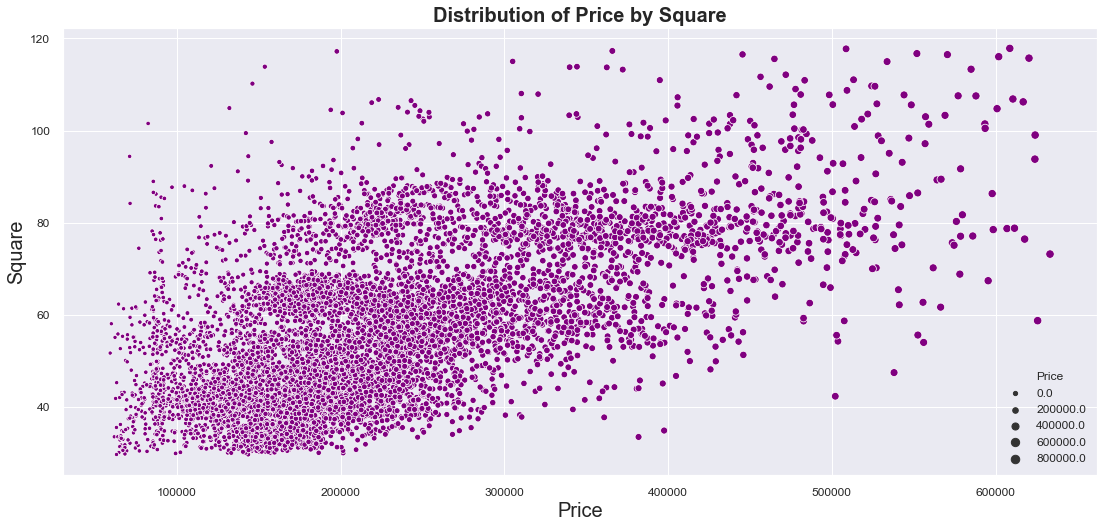

In [65]:
plt.figure(figsize=(16,8))
data=pd.read_csv('train.csv')

plt.ylabel('Count', size=20)
plt.xlabel('Price', size=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.scatterplot(train_df['Price'], train_df['Square'], color='purple', size=train_df['Price'], data=data)
plt.title('Distribution of Price by Square', size=20, fontweight='bold')
plt.legend(fancybox=True, shadow=True, fontsize=12)
plt.show()

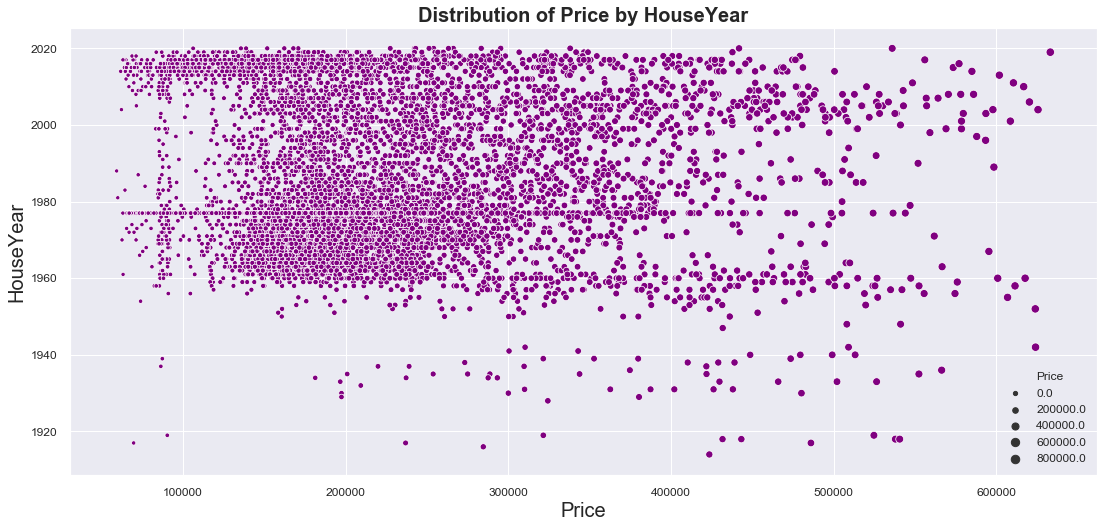

In [66]:
plt.figure(figsize=(16,8))
data=pd.read_csv('train.csv')

plt.ylabel('HouseYear', size=20)
plt.xlabel('Price', size=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.scatterplot(train_df['Price'], train_df['HouseYear'], color='purple', size=train_df['Price'], data=data)
plt.title('Distribution of Price by HouseYear', size=20, fontweight='bold')
plt.legend(fancybox=True, shadow=True, fontsize=12)
plt.show()

In [67]:
train_df.shape

(8881, 28)

In [68]:
test_df.shape

(5000, 19)

### Split train & test

In [69]:
train_df["Rooms_vc"] = train_df["Rooms"].map(train_df["Rooms"].value_counts().to_dict())
train_df["Rooms_vc"]

0       3537
1       1973
2       3537
3       3250
4       1973
        ... 
8876    3537
8877    3250
8878    3250
8879    3537
8880    3250
Name: Rooms_vc, Length: 8881, dtype: int64

In [70]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

### Create Model

In [72]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                  max_depth=8,
                                  min_samples_leaf=100,
                                  random_state=39,
                                  n_estimators=100)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=100, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=39, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Train R2:	0.847
Test R2:	0.719
Train RMSE:	35220.994
Test RMSE:	46941.735
Train MSE:	1240518420.011
Test MSE:	2203526463.744
Train Mean-Target: 215252.801
Test Mean-Target: 214303.429


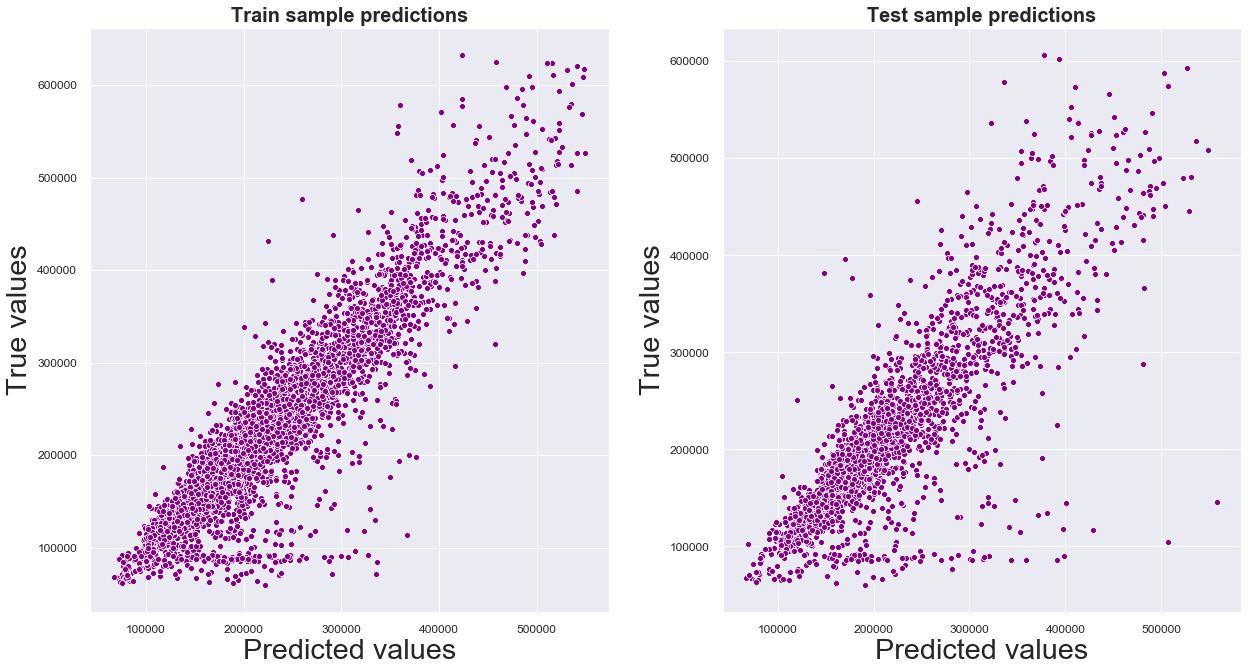

In [73]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Crossover check

In [74]:
cv_score = cross_val_score(
    gb_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.72340535, 0.72741109, 0.76111807, 0.76592185, 0.79437637])

In [75]:
cv_score.mean(), cv_score.std()

(0.7544465440074252, 0.026325100381569395)

In [76]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.7281214436258557, 0.7807716443889946)

### Feature importance

In [77]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.720743
1,Square,0.098240
19,MedPriceByHouseYear,0.044503
12,Social_3,0.021026
3,KitchenSquare,0.015545
5,HouseFloor,0.014222
6,HouseYear,0.013550
7,Ecology_1,0.013418
11,Social_2,0.010846
2,LifeSquare,0.010395


### Prediction file

In [78]:
test_id = test_df["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./ESevcenko_predictions.csv", index=False)

In [79]:
pred_df = pd.read_csv("./ESevcenko_predictions.csv")
pred_df.head(n=10)

,Id,Price
0,725,263228
1,15856,307644
2,5480,754795
3,15664,986689
4,14275,122359
5,7633,905907
6,13329,50131
7,5502,103787
8,4220,143014
9,11538,116350


In [80]:
test_df.shape[0]

5000